# Medical Image Classification

In [1]:
import os, math, json, random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
from PIL import Image


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import class_weight


import keras

from keras import optimizers
from keras.optimizers import Adam

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

Tensorflow version 1.14.0


Using TensorFlow backend.


## Analyse Data and Generate Train-, Val- and Test-Data

Plotting Normal Images


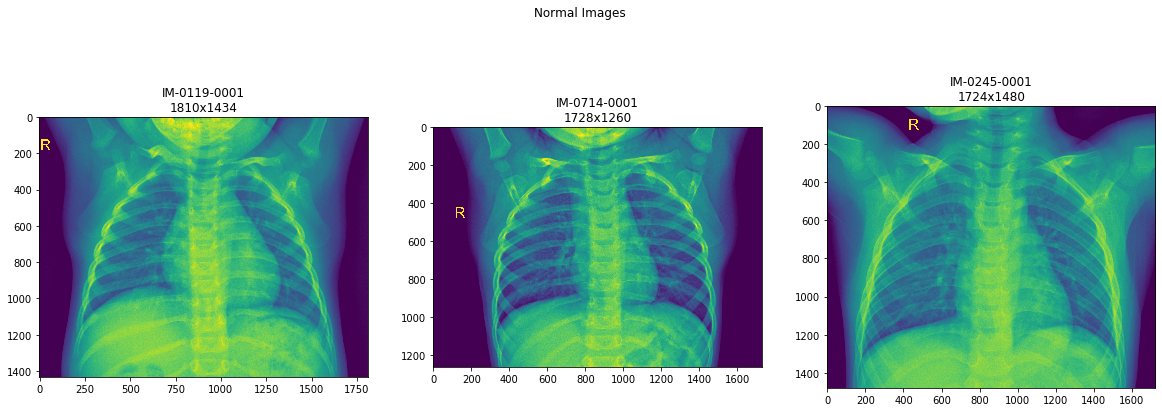

Plotting Pneumonia Images


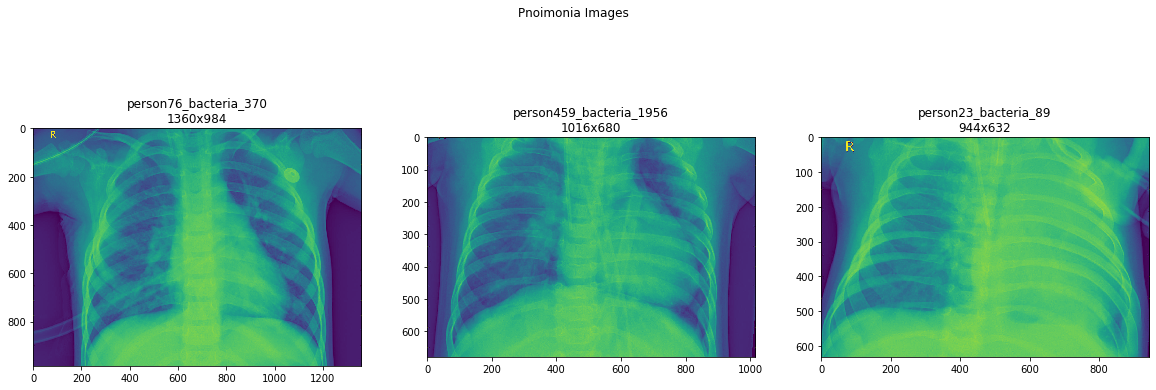

In [2]:
# Inception V3, Link to tensorFlow hub:
# https://tfhub.dev/google/imagenet/inception_v3/classification/3

# Setting directories; Val and test interchanged because in test-dir there're more pictures
train_dir = "chest_xray/train"
val_dir = "chest_xray/test"
test_dir = "chest_xray/val"



#Printing random Normal images
print("Plotting Normal Images")
plt.figure(figsize=(20, 7))
plt.suptitle("Normal Images")
for i in range(3):  
    imgname = random.choice(os.listdir(train_dir + '/Normal/'))
    if imgname.endswith('.jpeg'): # Check if jpeg-file
        img = mpimg.imread(train_dir + '/Normal/'+ imgname)
        
        # Getting image Size
        im = Image.open(train_dir + '/Normal/'+ imgname) # for Image Size
        imw, imh = im.size
        
        imtit = imgname.split('.')[0] +"\n" + str(imw) + "x" + str(imh)
        plt.subplot(131 + i)
        plt.title(imtit)
        imgplot = plt.imshow(img)
           
plt.show()


#Printing random Pneumonia images
print("Plotting Pneumonia Images")
plt.figure(figsize=(20, 7))
plt.suptitle("Pnoimonia Images")
for i in range(3):  
    imgname = random.choice(os.listdir(train_dir + '/Pneumonia/'))
    if imgname.endswith('.jpeg'): # Check if jpeg-file
        img = mpimg.imread(train_dir + '/Pneumonia/'+ imgname)
        
        # Getting image Size
        im = Image.open(train_dir + '/Pneumonia/'+ imgname) # for Image Size
        imw, imh = im.size
        
        imtit = imgname.split('.')[0] +"\n" + str(imw) + "x" + str(imh)
        plt.subplot(131 + i)
        plt.title(imtit)
        imgplot = plt.imshow(img)
           
plt.show()

In [3]:
# Generate Test Data

rescale = 1./255
target_size = (192, 192)
batch_size = 512 #256
class_mode = 'categorical'


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,  # Range for random zoom (1-zoomrange - 1+zoom_range)
    horizontal_flip=True) # Randomly flips horizontal


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Define Model

In [4]:
# Doku https://keras.io/applications/#inceptionv3

def get_model():    
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3)) #Img Size, RGB
    x = base_model.output 
    x = GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(50, activation = 'relu')(x)
    x = BatchNormalization()(x) # Normalizes activations of the previous layer at each batch.
    predictions = Dense(2, activation='softmax')(x) 
        
    model = Model(inputs=base_model.input, outputs=predictions) # Model: Includes all layers to combine input and output 
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model.summary()

    return model

In [5]:
model = get_model()

W0922 10:51:38.216206  5940 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 10:51:38.263067  5940 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 10:51:38.278694  5940 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 10:51:38.309946  5940 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0922 10:51:38.3

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 95, 95, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 95, 95, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
class_w = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

model.compile(optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=7,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_w
    )

W0922 10:52:04.840905  5940 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 10:52:04.950287  5940 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/7
11/11 [==============================] - 150s 14s/step - loss: 0.6579 - acc: 0.6953 - val_loss: 1.3299 - val_acc: 0.6554
Epoch 2/7
11/11 [==============================] - 126s 11s/step - loss: 0.4293 - acc: 0.8234 - val_loss: 0.9289 - val_acc: 0.6506
Epoch 3/7
11/11 [==============================] - 126s 11s/step - loss: 0.3570 - acc: 0.8614 - val_loss: 0.8093 - val_acc: 0.6987
Epoch 4/7
11/11 [==============================] - 125s 11s/step - loss: 0.3093 - acc: 0.8871 - val_loss: 0.8435 - val_acc: 0.7019
Epoch 5/7
11/11 [==============================] - 124s 11s/step - loss: 0.2977 - acc: 0.8943 - val_loss: 0.8315 - val_acc: 0.6891
Epoch 6/7
11/11 [==============================] - 124s 11s/step - loss: 0.2889 - acc: 0.9018 - val_loss: 0.7828 - val_acc: 0.6987
Epoch 7/7
11/11 [==============================] - 123s 11s/step - loss: 0.2582 - acc: 0.9130 - val_loss: 0.8594 - val_acc: 0.6939


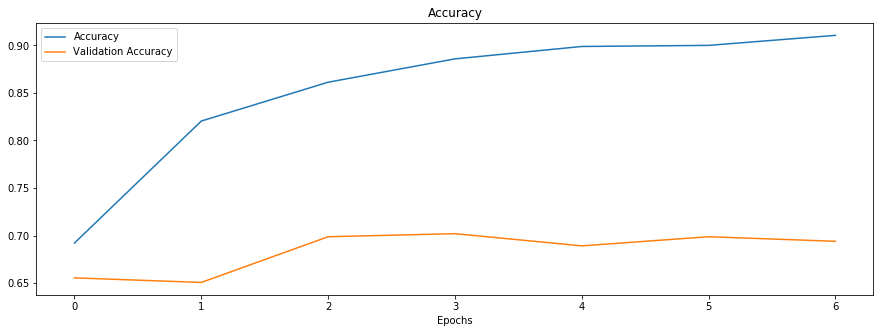

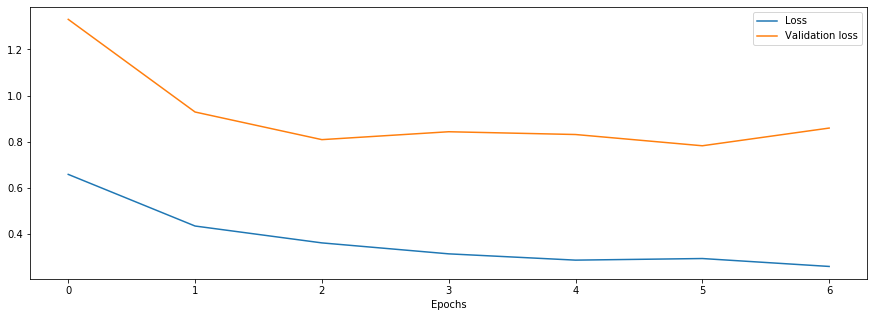

In [7]:
# Evaluate Model
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'], label = "Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure(figsize = (15,5))
plt.plot(history.history['loss'], label = "Loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Testing Model

In [8]:
# Test Data

result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print('Loss:', result[0])
#print('Accuracy:', result[1])
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
print(result)

1/1 [==============================] - 2s 2s/step
[1.2111464738845825, 0.625]


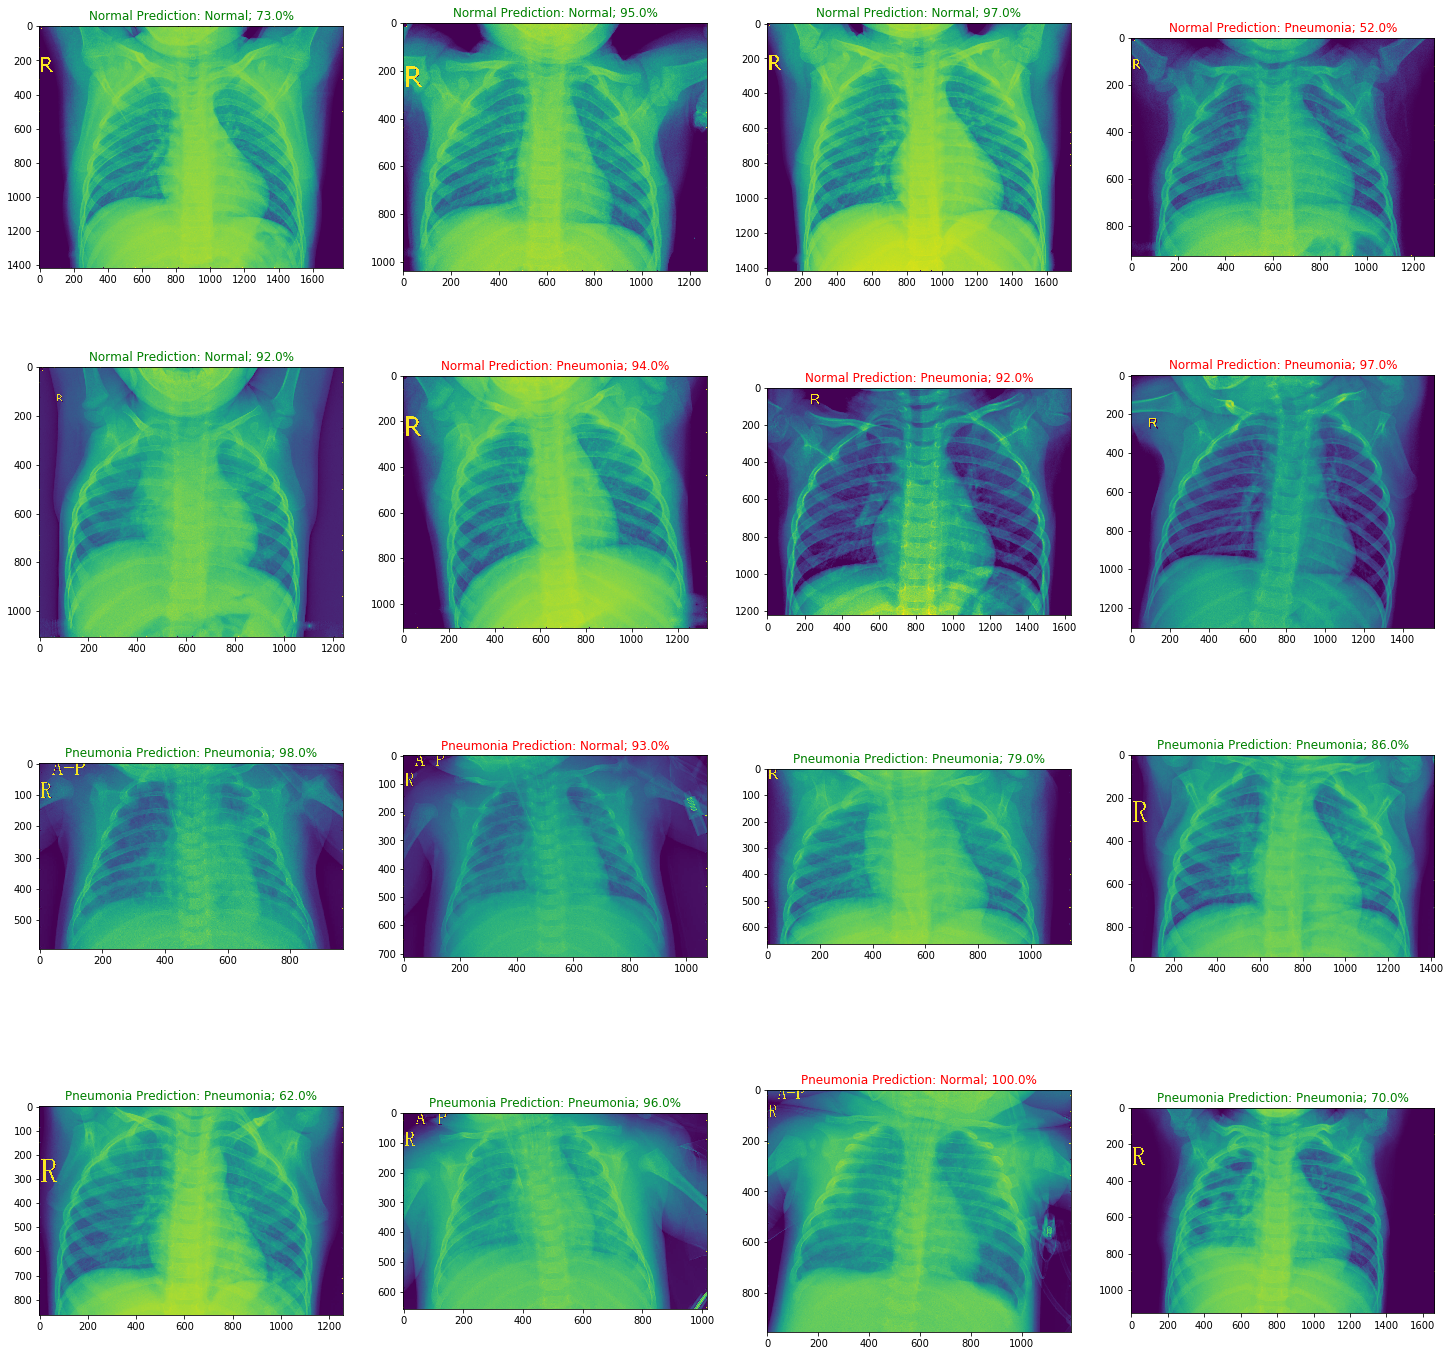

In [9]:
y_pred = predictions.argmax(axis=-1)
y_true = test_generator.classes
plt.figure(figsize=(25, 25))
for i in range(len(test_generator.filenames)):
        img = mpimg.imread(test_dir + '/' +test_generator.filenames[i])
        if y_true[i] == 0:
            imclass = "Normal"
        else:
            imclass = "Pneumonia"
            
        if y_pred[i] ==0:
            impred = "Normal"
            impro = predictions[i,0]
        else:
            impred = "Pneumonia"
            impro = predictions[i,1]
            
        imtit = imclass + " Prediction: " + impred +"; "+str(round(impro*100)) +"%"    
             
        plt.subplot(4,4,1 + i)
        if y_pred[i] == y_true[i]:
            plt.title(imtit, color ="g")
        else:
            plt.title(imtit, color ="r")
        imgplot = plt.imshow(img) 
plt.show()    